# Extensions to Linear Models - Lab

## Introduction

In this lab, you'll practice many concepts learned in this section, from adding interactions and polynomials to your model to AIC and BIC!

## Summary

You will be able to:
- Build a linear regression model with polynomial features/interactions
- Perform regularization
- Use AIC and BIC to select the best value for the regularization parameter


## Let's get started!

Import all the necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn import preprocessing

from sklearn.datasets import load_boston

## Look at a Baseline Boston Housing Data Model

Import the Boston housing data set, use all the predictors in their scaled version (using `preprocessing.scale`. Look at a baseline model using *scaled variables* as predictors. Use 5-fold cross-validation this time and use the $R^2$ score to evaluate the model.

In [2]:
# Your code here
regression = LinearRegression()
boston = load_boston()

In [50]:
y = pd.DataFrame(boston.target, columns=['target'])
df = pd.DataFrame(boston.data, columns=boston.feature_names)

X_scaled = preprocessing.scale(df)
X_scaled = pd.DataFrame(X_scaled, columns=boston.feature_names)

all_df = pd.concat([y,X_scaled], axis=1)

In [8]:
cv = KFold(n_splits=5, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(regression, X_scaled, y, scoring='r2', cv=cv))
baseline

0.7176324491383005

## Include interactions

Look at all the possible combinations of variables for interactions by adding interactions one by one to the baseline model. Next, evaluate that model using 5-fold classification and store the $R^2$ to compare it with the baseline model.

You've created code for this before in the interactions lab, yet this time, you have scaled the variables so the outcomes may look different. 

Print the 7 most important interactions.

In [34]:
# Your code here
from itertools import combinations

combos = list(combinations(boston.feature_names, 2))
X_copy = X_scaled.copy()

scores = []

for c in combos:
    X_copy['interactions'] = X_copy[c[0]] * X_copy[c[1]]
    cv = KFold(n_splits=5, shuffle=True, random_state=1)
    score = np.mean(cross_val_score(regression, X_copy, y, scoring='r2', cv=cv))
    if score > baseline:
        scores.append((score,c))
        
print(sorted(scores, reverse=True)[:7])   


[(0.7832165803604273, ('RM', 'LSTAT')), (0.7752514777398676, ('RM', 'TAX')), (0.7700767546577312, ('RM', 'RAD')), (0.7635456330512322, ('RM', 'PTRATIO')), (0.7566187103630421, ('INDUS', 'RM')), (0.7461351850787393, ('NOX', 'RM')), (0.7421152576041224, ('RM', 'AGE'))]


Write code to include the 7 most important interactions in your data set by adding 7 columns. Name the columns "var1_var2" with var1 and var2 the two variables in the interaction.

In [35]:
# Your code here
top_7 = sorted(scores, reverse=True)[:7]
df_inter = X_scaled.copy()
for s,c in top_7:
    df_inter[c[0]+'_'+c[1]] = df_inter[c[0]] * df_inter[c[1]]
    
df_inter.head()    

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,RM_LSTAT,RM_TAX,RM_RAD,RM_PTRATIO,INDUS_RM,NOX_RM,RM_AGE
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,0.413672,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,0.441052,-1.075562,-0.444930,-0.275757,-0.406574,-0.603547,-0.532772,-0.059659,-0.049646
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.194274,0.367166,0.557160,-0.867883,-0.987329,-0.303094,0.441052,-0.492439,-0.095668,-0.191813,-0.168607,-0.058883,-0.115279,-0.143814,0.071331
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,1.282714,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,0.396427,-1.208727,-1.550451,-1.266461,-1.113245,-0.388783,-0.761138,-0.949544,-0.340960
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,1.016303,-0.809889,1.077737,-0.752922,-1.106115,0.113032,0.416163,-1.361517,-1.383713,-1.124148,-0.765197,0.114875,-1.328183,-0.848901,-0.823092
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,1.228577,-0.511180,1.077737,-0.752922,-1.106115,0.113032,0.441052,-1.026501,-1.261136,-1.358947,-0.925023,0.138869,-1.605599,-1.026210,-0.628023


## Include Polynomials

Try polynomials of 2, 3 and 4 for each variable, in a similar way you did for interactions (by looking at your baseline model and seeing how $R^2$ increases). Do understand that when going for a polynomial of 4, the particular column is raised to the power of 2 and 3 as well in other terms. We only want to include "pure" polynomials, so make sure no interactions are included. We want the result to return a list that contain tuples of the form:

`(var_name, degree, R2)`, so eg. `('DIS', 3, 0.732)`

In [21]:
# always generate polynomiaFeatures BEFORE scaling
from sklearn.preprocessing import PolynomialFeatures
polynomials = []
for col in df.columns:
    for degree in [2,3,4]:
        x_copy = X_scaled.copy()
        poly = PolynomialFeatures(degree, include_bias=False)
        X = poly.fit_transform(df[[col]])
        x_copy = pd.concat([x_copy.drop(col,axis=1),pd.DataFrame(X)], axis=1)
        score = np.mean(cross_val_score(regression, x_copy, y, scoring='r2', cv=cv))
        if score > baseline:
            polynomials.append((col, degree, score))

For each variable, print out the maximum R2 possible when including Polynomials.

In [31]:
# Your code here
polys = pd.DataFrame(polynomials)
polys.groupby([0,1], sort=False)[2].max()
    

0        1
ZN       2    0.720420
         3    0.723175
         4    0.719769
INDUS    2    0.722992
         3    0.723253
         4    0.723221
CHAS     4    0.717632
NOX      2    0.718076
         3    0.718304
         4    0.720555
RM       2    0.782271
         3    0.780715
         4    0.800385
AGE      2    0.720900
         3    0.722149
         4    0.722107
DIS      2    0.731965
         3    0.736625
         4    0.730780
RAD      4    0.719489
TAX      2    0.718751
         3    0.720932
         4    0.723968
PTRATIO  2    0.720892
         3    0.719284
B        2    0.719702
         3    0.719442
         4    0.717854
LSTAT    2    0.771852
         3    0.774011
         4    0.781889
Name: 2, dtype: float64

Which two variables seem to benefit most from adding Polynomial terms?

Add Polynomials for the two features that seem to benefit the most, as in have the best R squared compared to the baseline model. For each of the two feature, raise to the Polynomial that generates the best result. Make sure to start from the data set `df_inter` so the final data set has both interactions and polynomials in the model.

In [36]:
# Your code here
for col in ["RM", "LSTAT"]:
    poly = PolynomialFeatures(4, include_bias=False)
    X = poly.fit_transform(df[[col]])
    colnames= poly.get_feature_names(col)
    df_inter = pd.concat([df_inter.drop(col, axis=1),pd.DataFrame(X, columns=colnames)], axis = 1)

check out your final data set and make sure that your interaction terms as well as your polynomial terms are included.

In [37]:
# Your code here
df_inter.head()

,CRIM,ZN,INDUS,CHAS,NOX,AGE,DIS,RAD,TAX,PTRATIO,...,NOX_RM,RM_AGE,R,R^2,R^3,R^4,L,L^2,L^3,L^4
0,-0.417713,0.284830,-1.287909,-0.272599,-0.144217,-0.120013,0.140214,-0.982843,-0.666608,-1.459000,...,-0.059659,-0.049646,6.575,43.230625,284.241359,1868.886938,4.98,24.8004,123.505992,615.059840
1,-0.415269,-0.487722,-0.593381,-0.272599,-0.740262,0.367166,0.557160,-0.867883,-0.987329,-0.303094,...,-0.143814,0.071331,6.421,41.229241,264.732956,1699.850313,9.14,83.5396,763.551944,6978.864768
2,-0.415272,-0.487722,-0.593381,-0.272599,-0.740262,-0.265812,0.557160,-0.867883,-0.987329,-0.303094,...,-0.949544,-0.340960,7.185,51.624225,370.920057,2665.060607,4.03,16.2409,65.450827,263.766833
3,-0.414680,-0.487722,-1.306878,-0.272599,-0.835284,-0.809889,1.077737,-0.752922,-1.106115,0.113032,...,-0.848901,-0.823092,6.998,48.972004,342.706084,2398.257176,2.94,8.6436,25.412184,74.711821
4,-0.410409,-0.487722,-1.306878,-0.272599,-0.835284,-0.511180,1.077737,-0.752922,-1.106115,0.113032,...,-1.026210,-0.628023,7.147,51.079609,365.065966,2609.126456,5.33,28.4089,151.419437,807.065599


## Full model R-squared

Check out the R-squared of the full model.

In [38]:
# Your code here
np.mean(cross_val_score(regression, df_inter, y, scoring='r2', cv=cv))

0.8061116489236977

## Finding the best Lasso regularization parameter

You've learned that, when using Lasso regularization, your coefficients shrink to 0 when using a higher regularization parameter. Now the question is which value we should choose for the regularization parameter. 

This is where the AIC and BIC come in handy! We'll use both criteria in what follows and perform cross-validation to select an optimal value of the regularization parameter alpha of the Lasso estimator.

Read the page here: https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html and create a similar plot as the first one listed on the page. 

In [39]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

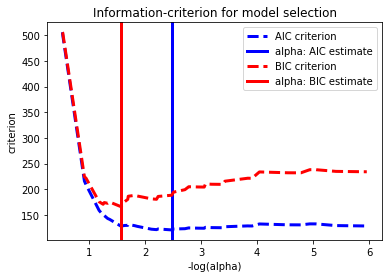

In [45]:
# Your code here
model_bic = LassoLarsIC(criterion='bic')
model_bic.fit(df_inter, y)
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(df_inter, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection');
          

## Analyze the final result

Finally, use the best value for regularization parameter according to AIC and BIC and compare the R squared parameters and MSE using train-test-split. Compare with the baseline model.

In [57]:
# Code for baseline model
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y)

linreg_all = LinearRegression()
linreg_all.fit(X_train, y_train)
print('Training r^2:', linreg_all.score(X_train, y_train))
print('Testing r^2:', linreg_all.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, linreg_all.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, linreg_all.predict(X_test)))


Training r^2: 0.7163087807237563
Testing r^2: 0.7771537365132459
Training MSE: 21.998585000685544
Testing MSE: 23.023231077164624


In [64]:
# code for lasso with alpha from AIC
X_train, X_test, y_train, y_test = train_test_split(df_inter, y)

lasso = Lasso(alpha= alpha_aic_) 
lasso.fit(X_train, y_train)
print('Training r^2:', lasso.score(X_train, y_train))
print('Testing r^2:', lasso.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

Training r^2: 0.831156750749461
Testing r^2: 0.8284615392150575
Training MSE: 14.26163366280747
Testing MSE: 14.438317477365572


In [65]:
# code for lasso with alpha from BIC

lasso = Lasso(alpha= alpha_bic_) 
lasso.fit(X_train, y_train)
print('Training r^2:', lasso.score(X_train, y_train))
print('Testing r^2:', lasso.score(X_test, y_test))
print('Training MSE:', mean_squared_error(y_train, lasso.predict(X_train)))
print('Testing MSE:', mean_squared_error(y_test, lasso.predict(X_test)))

Training r^2: 0.8302772334124529
Testing r^2: 0.8306152275667797
Training MSE: 14.33592359809464
Testing MSE: 14.257042467509578


## Level Up - Optional

### Create a Lasso Path

From this section, you know that when using lasso, more parameters shrink to zero as your regularization parameter goes up. In Scikit-Learn there is a function lasso_path which visualizes the shrinkage of the coefficients while alpha changes. Try this out yourself!

https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_coordinate_descent_path.html#sphx-glr-auto-examples-linear-model-plot-lasso-coordinate-descent-path-py

### AIC and BIC for subset selection
This notebook shows how you can use AIC and BIC purely for feature selection. Try this code out on our Boston Housing data!

https://xavierbourretsicotte.github.io/subset_selection.html

## Summary

Congratulations! You now know how to create better linear models and how to use AIC and BIC for both feature selection and to optimize your regularization parameter when performing Ridge and Lasso. 